# Manual Feature Engineering on the Retail Dataset

In this notebook we will work with a dataset of online retail transactions. This data is originally from [the UCI Machine Learning Repository.](https://archive.ics.uci.edu/ml/datasets/online+retail#) and is a great example of real-world time-series data. Our objective will be to develop a model that can predict the spending of a customer in the next month given the past spending data for that customer. 

In the automated feature engineering notebook, we saw how to solve this problem using Featuretools in a machine learning pipeline. We were able to build a model that ourperformed the baseline in terms of our metrics (F1 and ROC AUC). In this notebook, we'll approach the problem completely by hand, relying on our own abilities as data scientists to develop a set of valid, relevant features for the prediction problem. 

__For this notebook, I decided to give myself the same time as the entire Featuretools implementation: 60 minutes. The goal is to see if I could create an adequate model using manual feature engineering in the same time as automated feature engineering.__

In [1]:
# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Automated feature engineering
import featuretools as ft

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

First let's load in the raw data and take a look. We'll apply the same data formatting principles 

In [2]:
csv_s3 = "s3://featurelabs-static/online-retail-logs.csv"
data = pd.read_csv(csv_s3, parse_dates=["order_date"])

# Convert to dollars
data['price'] = data['price'] * 1.65
data['total'] = data['price'] * data['quantity']

# Restrict data to 2011
data = data[data['order_date'].dt.year == 2011]

# drop the duplicates
data = data.drop_duplicates()

# drop rows with null customer id
data = data.dropna(axis=0)

data.head()

order_id product_id                description  quantity  \
42481   539993      22386    JUMBO BAG PINK POLKADOT        10   
42482   539993      21499         BLUE POLKADOT WRAP        25   
42483   539993      21498        RED RETROSPOT WRAP         25   
42484   539993      22379   RECYCLING BAG RETROSPOT          5   
42485   539993      20718  RED RETROSPOT SHOPPER BAG        10   

               order_date   price  customer_id         country   total  
42481 2011-01-04 10:00:00  3.2175      13313.0  United Kingdom  32.175  
42482 2011-01-04 10:00:00  0.6930      13313.0  United Kingdom  17.325  
42483 2011-01-04 10:00:00  0.6930      13313.0  United Kingdom  17.325  
42484 2011-01-04 10:00:00  3.4650      13313.0  United Kingdom  17.325  
42485 2011-01-04 10:00:00  2.0625      13313.0  United Kingdom  20.625

# Load in Prediction Problem

We already created the prediction problem in the automated feature engineering notebook. The objective is to predict the total spending of customers in the next month. Instead of forecasting the amount, we decided to group customers into a segment that spends more than \$500 and a segment spending less. 

Each customer is represented in the labels multiple times, once for each month that we want to predict. Using customers multiple times allows us to construct more labelled training examples. However, it also means that we must be careful in the data we use.

In [3]:
labels = pd.read_csv('../input/labels.csv', index_col=0)
labels.head()

customer_id cutoff_time       total  label
0      12352.0  2011-03-01    502.7220      1
1      12383.0  2011-03-01    589.1655      1
2      12388.0  2011-03-01    347.9850      0
3      12395.0  2011-03-01    538.7250      1
4      12415.0  2011-03-01  27320.9310      1

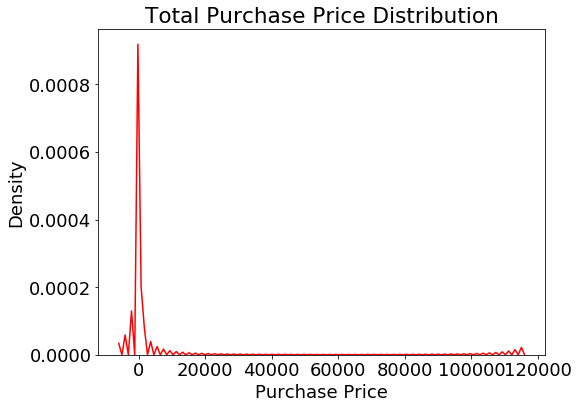

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['font.size'] = 18
from IPython.core.pylabtools import figsize
figsize(8, 6)

# KDE plot of total price
sns.distplot(labels['total'], hist=False, color = 'red');
plt.title('Total Purchase Price Distribution');
plt.xlabel('Purchase Price'); plt.ylabel('Density');

In [5]:
def ecdf(a):
    x = np.sort(a)
    y = np.arange(len(x)) / float(len(x))
    return x, y

The 90th percentile is at $792.76


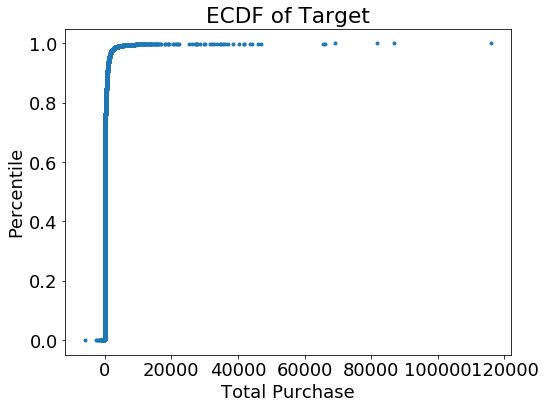

In [6]:
x, y = ecdf(labels['total'])
plt.plot(x, y, '.');
plt.xlabel('Total Purchase'); plt.ylabel('Percentile'); plt.title('ECDF of Target');
print(f'The 90th percentile is at ${round(x[np.where(y > 0.9)[0][0]], 2)}')

In [7]:
print(f'There are {len(data)} observations in the final data with {data["customer_id"].nunique()} unique customers.')
print(f'There are {len(labels)} labels.')

There are 375250 observations in the final data with 4244 unique customers.
There are 28133 labels.


# Feature Engineering

Once we have our machine learning task, we need to figure out how to get the data into a format for training a model. For each label (customer - month) we are going to need one row of data, with the columns forming the features. The tricky part is that we must be sure to not use any future data for predicting in a given month. As a first pass, we can limit ourselves to trying to build a model to make predictions for December 2011. Since this is the last month in the dataset, we should have the most data and be able to build an accurate model. 

Feature engineering will require us to aggregate information that is no the purchase level into information on the customer level. We need to try and create features that are relevant for predicting how much a customer will spend in the future. We can do this by incorporating domain knowledge and building features either one at a time, or in groups using multiple aggregations at once.

## Enriching the data

One of the simplest feature engineering steps is to extract information from the original data such as by finding the `weekday`, `month`, `hour`, and `minute` of the purchase. (These are referred to as transform primitives in Featuretools).

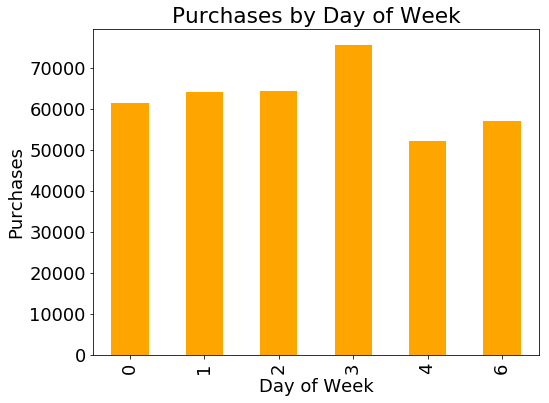

In [8]:
data['weekday'] = data['order_date'].dt.weekday
data['month'] = data['order_date'].dt.month
data['minute'] = data['order_date'].dt.minute
data['hour'] = data['order_date'].dt.hour
data['date_only'] = data['order_date'].dt.date

# Plot of purchases by day of week
data['weekday'].value_counts().sort_index().plot.bar(color = 'orange');
plt.title('Purchases by Day of Week'); plt.ylabel('Purchases'); plt.xlabel('Day of Week');

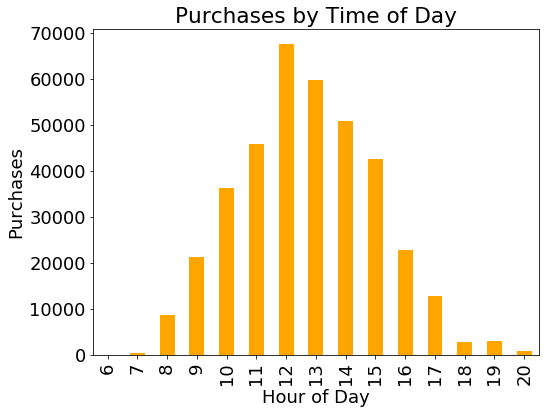

In [9]:
data['hour'].value_counts().sort_index().plot.bar(color = 'orange');
plt.title('Purchases by Time of Day'); plt.ylabel('Purchases'); plt.xlabel('Hour of Day');

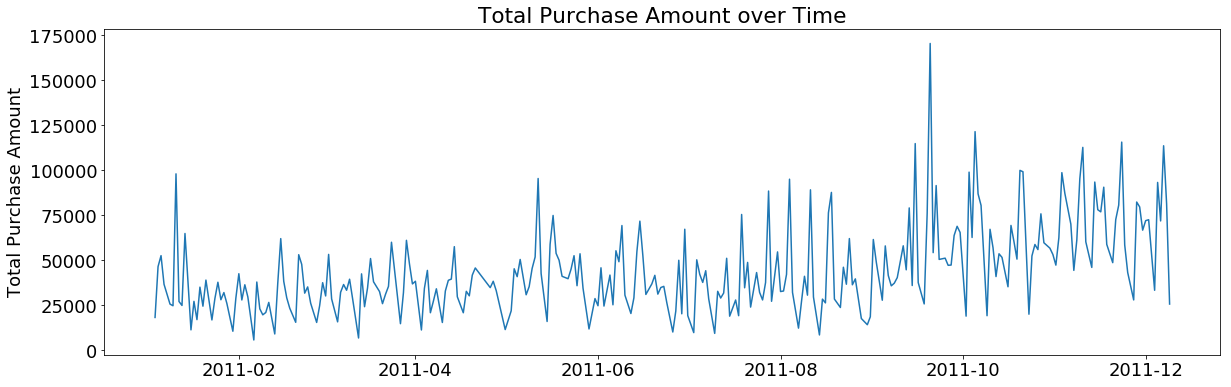

In [10]:
figsize(20, 6)
trends = data.groupby('date_only')['total'].sum()
trends.plot()
plt.title('Total Purchase Amount over Time'); plt.xlabel(''); plt.ylabel('Total Purchase Amount');

We can't yet use these features for machine learning since they are still on a _purchase_ level. We need features on a _customer_ level. 

### Subset to Valid Data

Before we go any further, we are going to want to subset to the valid data. Our first goal is to predict only December spending, so for our training data, we'll limit ourselves to data before November while our testing data will use only information in November. The training labels are for customer - months from November and before, and the testing labels are those from December. This is the same method we used for assessing the Featuretools model. 

To summarize if we are making predictions for December 2011:

* Training data: anything from before November 2011
* Testing data: data from November 2011
* Training labels: customer - months from before December 2011
* Testing labels: customer spending in December 2011

The following code subsets the data.

In [11]:
labels['cutoff_time'] = pd.to_datetime(labels['cutoff_time'])
labels['month'] = labels['cutoff_time'].dt.month

In [12]:
train = data[data['month'] < 11]
test = data[data['month'] == 11]
train_labels = labels.loc[labels['month'] < 12, ['customer_id', 'label', 'month']]
test_labels = labels.loc[labels['month'] == 12, ['customer_id', 'label', 'month']]

Let's quickly look at the results of an informed baseline guess for December. This guess comes from using the spending of the customer in November (the previous month) as the prediction in the next month.

In [13]:
def informed_baseline(month_number, threshold = 500, quiet = False):
    """Calculate an informed baseline for a given month. 
    The informed baseline is guessing the previous month's spending
    for the next month. The probability is assessed by dividing
    the previous month's total by the threshold and setting
    any values greater than 1 to 1."""
    
    # Subset to the months
    month = labels[labels['month'] == month_number]
    previous_month = labels[labels['month'] == (month_number - 1)]
    
    previous_month = previous_month.rename(columns = {'total': 'previous_total'})

    # Merge the current month with the previous month
    month = month.merge(previous_month[['customer_id', 'previous_total']], on = 'customer_id', how = 'left')
    
    month['previous_total'] = month['previous_total'].fillna(0)
    month['probability'] = month['previous_total'] / threshold
    
    # Set probabilities greater than 1 equal to 1
    month.loc[month['probability'] > 1, 'probability'] = 1
    
    # Make the predicted label
    month['prediction'] = (month['previous_total'] > threshold).astype(int)
    if not quiet:
        print('Precision: {:.5f}.'.format(precision_score(month['label'], month['prediction'])))
        print('Recall: {:.5f}.'.format(recall_score(month['label'], month['prediction'])))
        print('F1 Score: {:.5f}.'.format(f1_score(month['label'], month['prediction'])))
        print('ROC AUC Score: {:.5f}.'.format(roc_auc_score(month['label'], month['probability'])))
    
    return month

In [14]:
december_informed = informed_baseline(12)

Precision: 0.21606.
Recall: 0.57547.
F1 Score: 0.31416.
ROC AUC Score: 0.69502.


This gives us a target to beat: if our model is not better than the informed baseline, then we are better off using the baseline instead of machine learning! In the automated feature engineering notebook, the best model was able to score __0.81378 ROC AUC__, significantly better than the baseline.

## Simple Feature Engineering

As a first pass at feature engineering, we can group by the month and the customer and calculate numerical aggregations of the purchase data. We'll then join the data for one month to the prediction for the following month to ensure that our data comes before our labels.

In [15]:
train_agg = train.groupby(['customer_id', 'month']).agg(['mean', 'max', 'min', 'sum', 'count'])

new_cols = []
for col in train_agg.columns.levels[0]:
    for stat in train_agg.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')
        
train_agg.columns = new_cols
train_agg.head()

quantity-mean  quantity-max  quantity-min  quantity-sum  \
customer_id month                                                            
12346.0     1           0.000000         74215        -74215             0   
12347.0     1          10.862069            24             3           315   
            4          20.125000           240             3           483   
            6          10.888889            36             2           196   
            8          12.590909            36             3           277   

                   quantity-count  price-mean  price-max  price-min  \
customer_id month                                                     
12346.0     1                   2    1.716000     1.7160     1.7160   
12347.0     1                  29    4.163121    21.0375     0.6930   
            4                  24    4.282437    21.0375     0.4125   
            6                  18    4.915167    16.4175     0.4950   
            8                  22    5.118000    21.0375     0.9075   

                   price-sum  price-count     ...      minute-mean  \
customer_id month                             ...                    
12346.0     1         3.4320            2     ...              9.0   
12347.0     1       120.7305           29     ...             30.0   
            4       102.7785           24     ...             43.0   
            6        88.4730           18     ...              1.0   
            8       112.5960           22     ...             48.0   

                   minute-max  minute-min  minute-sum  minute-count  \
customer_id month                                                     
12346.0     1              17           1          18             2   
12347.0     1              30          30         870            29   
            4              43          43        1032            24   
            6               1           1          18            18   
            8              48          48        1056            22   

                   hour-mean  hour-max  hour-min  hour-sum  hour-count  
customer_id month                                                       
12346.0     1           10.0        10        10        20           2  
12347.0     1           14.0        14        14       406          29  
            4           10.0        10        10       240          24  
            6           13.0        13        13       234          18  
            8            8.0         8         8       176          22  

[5 rows x 30 columns]

Since we're aggregating for the previous month, we need to add one to the month and join with the labels. 

In [16]:
train_agg.reset_index(inplace = True)
train_agg['month'] = train_agg['month'] + 1
train_agg.set_index(['customer_id', 'month'], inplace = True)

In [17]:
train_data = train_labels.merge(train_agg, on = ['customer_id', 'month'], how = 'left')

Now the stats for the _previous_ month are associated with the label. So the stats for June are going to be used to predict the label for July.

In [18]:
test_agg = test.groupby(['customer_id', 'month']).agg(['mean', 'max', 'min', 'sum', 'count'])

new_cols = []
for col in test_agg.columns.levels[0]:
    for stat in test_agg.columns.levels[1]:
        new_cols.append(f'{col}-{stat}')
        
test_agg.columns = new_cols
test_agg.reset_index(inplace = True)
test_agg['month'] = test_agg['month'] + 1
test_agg.set_index(['customer_id', 'month'], inplace = True)
test_data = test_labels.merge(test_agg, on = ['customer_id', 'month'], how = 'left')

The same thing applies for the test data. The information in each row comes from November because the label is for December. 

In [19]:
test_data.head()

customer_id  label  month  quantity-mean  quantity-max  quantity-min  \
0      12347.0      0     12            NaN           NaN           NaN   
1      12358.0      1     12            NaN           NaN           NaN   
2      12359.0      0     12            NaN           NaN           NaN   
3      12362.0      1     12      10.684211          36.0          -3.0   
4      12364.0      1     12            NaN           NaN           NaN   

   quantity-sum  quantity-count  price-mean  price-max     ...      \
0           NaN             NaN         NaN        NaN     ...       
1           NaN             NaN         NaN        NaN     ...       
2           NaN             NaN         NaN        NaN     ...       
3         203.0            19.0    6.302132      24.75     ...       
4           NaN             NaN         NaN        NaN     ...       

   minute-mean  minute-max  minute-min  minute-sum  minute-count  hour-mean  \
0          NaN         NaN         NaN         NaN           NaN        NaN   
1          NaN         NaN         NaN         NaN           NaN        NaN   
2          NaN         NaN         NaN         NaN           NaN        NaN   
3    14.578947        55.0         7.0       277.0          19.0   9.789474   
4          NaN         NaN         NaN         NaN           NaN        NaN   

   hour-max  hour-min  hour-sum  hour-count  
0       NaN       NaN       NaN         NaN  
1       NaN       NaN       NaN         NaN  
2       NaN       NaN       NaN         NaN  
3      14.0       9.0     186.0        19.0  
4       NaN       NaN       NaN         NaN  

[5 rows x 33 columns]

Now let's train and test a model.

In [20]:
from utils import feature_selection

train_data = feature_selection(train_data)
test_data = test_data[train_data.columns]

Original shape:  (23936, 33)
0 missing columns with threshold: 90.
0 zero variance columns.
7 collinear columns removed with threshold: 0.95.
Total columns removed:  7
Shape after feature selection: (23936, 26).


In [21]:
feature_names = train_data.drop(columns = ['customer_id', 'label', 'month']).columns

pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
train_ready = pipeline.fit_transform(train_data.drop(columns = ['customer_id', 'label', 'month']))
test_ready = pipeline.transform(test_data.drop(columns = ['customer_id', 'label', 'month']))

In [22]:
model = RandomForestClassifier(n_estimators=1000, n_jobs = -1, random_state=50)
model.fit(train_ready, train_data['label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

In [23]:
predictions = model.predict(test_ready)

predictions = model.predict(test_ready)
probs = model.predict_proba(test_ready)[:, 1]

# Calculate metrics
p = precision_score(test_labels['label'], predictions)
r = recall_score(test_labels['label'], predictions)
f = f1_score(test_labels['label'], predictions)
auc = roc_auc_score(test_labels['label'], probs)

print(f'Precision: {round(p, 5)}')
print(f'Recall: {round(r, 5)}')
print(f'F1 Score: {round(f, 5)}')
print(f'ROC AUC: {round(auc, 5)}')

# Feature importances
fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})

Precision: 0.37727
Recall: 0.26101
F1 Score: 0.30855
ROC AUC: 0.75145


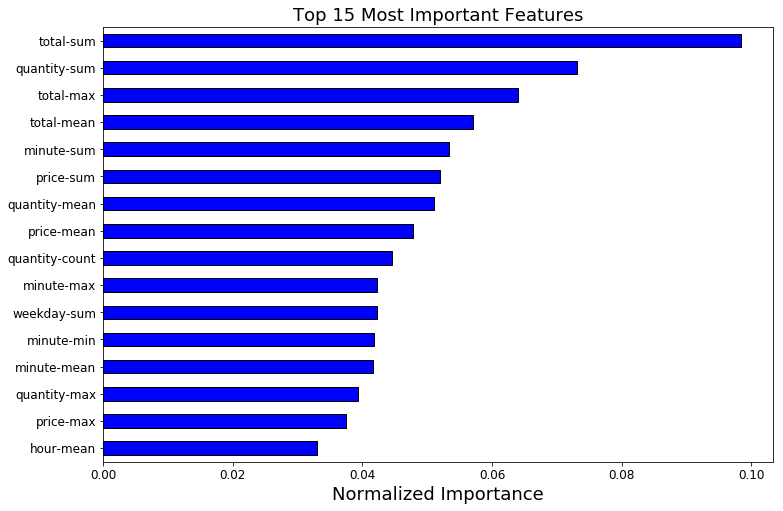

In [24]:
from utils import plot_feature_importances
norm_fi = plot_feature_importances(fi)

Our first attempt at a model does slightly better than the baseline but performs worse in terms of F1 score. The most important features do make sense though because the total spent previously or the total quantity purchased previously are good indicators of how much a customer will purchase in the future. 

Let's take this code and use it in a function so we can make predictions for any month.

### Function for Aggregating and Predicting Monthly Data

In [25]:
def predict_month(month):
    train = data[data['month'] < (month - 1)]
    test = data[data['month'] == (month - 1)]
    train_labels = labels.loc[labels['month'] < month, ['customer_id', 'label', 'month']]
    test_labels = labels.loc[labels['month'] == month, ['customer_id', 'label', 'month']]
    
    train_agg = train.groupby(['customer_id', 'month']).agg(['mean', 'max', 'min', 'sum', 'count'])

    new_cols = []
    for col in train_agg.columns.levels[0]:
        for stat in train_agg.columns.levels[1]:
            new_cols.append(f'{col}-{stat}')

    train_agg.columns = new_cols

    train_data = train_labels.merge(train_agg, on = ['customer_id', 'month'], how = 'left').fillna(0)

    feature_names = train_data.drop(columns = ['customer_id', 'label', 'month']).columns
    
    test_agg = test.groupby(['customer_id', 'month']).agg(['mean', 'max', 'min', 'sum', 'count'])

    new_cols = []
    for col in test_agg.columns.levels[0]:
        for stat in test_agg.columns.levels[1]:
            new_cols.append(f'{col}-{stat}')

    test_agg.columns = new_cols
    test_agg.reset_index(inplace = True)
    test_agg['month'] = test_agg['month'] + 1
    test_agg.set_index(['customer_id', 'month'], inplace = True)
    test_data = test_labels.merge(test_agg, on = ['customer_id', 'month'], how = 'left').fillna(0)

    pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                          ('scaler', MinMaxScaler())])

    # Fit and transform training data
    train_ready = pipeline.fit_transform(train_data.drop(columns = ['customer_id', 'label', 'month']))
    test_ready = pipeline.transform(test_data.drop(columns = ['customer_id', 'label', 'month']))

    model = RandomForestClassifier(n_estimators=1000, n_jobs = -1, random_state=50)
    model.fit(train_ready, train_data['label'])

    predictions = model.predict(test_ready)

    predictions = model.predict(test_ready)
    probs = model.predict_proba(test_ready)[:, 1]

    # Calculate metrics
    p = precision_score(test_labels['label'], predictions)
    r = recall_score(test_labels['label'], predictions)
    f = f1_score(test_labels['label'], predictions)
    auc = roc_auc_score(test_labels['label'], probs)

    print(f'Precision: {round(p, 5)}')
    print(f'Recall: {round(r, 5)}')
    print(f'F1 Score: {round(f, 5)}')
    print(f'ROC AUC: {round(auc, 5)}')

    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    return fi


In [26]:
july_fi = predict_month(7)

Precision: 0.36229
Recall: 0.43653
F1 Score: 0.39596
ROC AUC: 0.66162


In [27]:
_ = informed_baseline(7)

Precision: 0.41784.
Recall: 0.39644.
F1 Score: 0.40686.
ROC AUC Score: 0.64365.


In [28]:
print('Model Results\n')
august_fi = predict_month(8)

print('Baseline Results\n')
_ = informed_baseline(8)

Model Results

Precision: 0.34909
Recall: 0.42857
F1 Score: 0.38477
ROC AUC: 0.66284
Baseline Results

Precision: 0.40089.
Recall: 0.40179.
F1 Score: 0.40134.
ROC AUC Score: 0.66544.


It should not be that surprising our model doesn't do better than the baseline. Our aggregations are _only using the past month_ and therefore are essentially doing the same process as the informed guess. In order to try and perform better, we should make features for each label using all the previous data for the customer. That means for the June labels, we do not just use information from May, but from the entire sequence of data for the customer. 

## Including More Information

We can rewrite the code to aggregate information over all the previous months for each label. 

In [29]:
def predict_month_expanded(month, return_probs = False):
    
    train = data[data['month'] < (month - 1)]
    test = data[data['month'] < month ]
    
    # Training labels are from all previous months
    train_labels = labels.loc[labels['month'] < month, ['customer_id', 'label', 'month']]
    
    # Test labels are from a single month
    test_labels = labels.loc[labels['month'] == month, ['customer_id', 'label', 'month']]
    
    # Iterate through each month
    for i, train_month in enumerate(train_labels['month'].unique()):

        # Training data is from all months before the label
        train_agg = train.loc[train['month'] < train_month].groupby(['customer_id']).agg(['mean', 'max', 'min', 'sum', 'count'])

        # Rename the columns
        new_cols = []
        for col in train_agg.columns.levels[0]:
            for stat in train_agg.columns.levels[1]:
                new_cols.append(f'{col}-{stat}')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        # Set the month for joining to the labels
        train_agg['month'] = train_month
        
        # Create a dataframe of the training data
        if i == 0:
             all_train_data = train_agg.copy()
                
        else:
            all_train_data = all_train_data.append(all_train_data)
        
    # Join with the labels on the customer and month
    all_train_data = train_labels.merge(all_train_data, on = ['customer_id', 'month'], how = 'left')
        
    feature_names = all_train_data.drop(columns = ['customer_id', 'label', 'month']).columns
    
    # Test data is already subsetted to all previous months
    test_agg = test.groupby(['customer_id']).agg(['mean', 'max', 'min', 'sum', 'count'])
    
    # Rename the columns
    new_cols = []
    for col in test_agg.columns.levels[0]:
        for stat in test_agg.columns.levels[1]:
            new_cols.append(f'{col}-{stat}')

    test_agg.columns = new_cols
    # test_agg.set_index(['customer_id', 'month'], inplace = True)
    test_data = test_labels.merge(test_agg, on = ['customer_id'], how = 'left')

    pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                          ('scaler', MinMaxScaler())])

    # Imputer the missing values and scale
    train_ready = pipeline.fit_transform(all_train_data.drop(columns = ['customer_id', 'label', 'month']))
    test_ready = pipeline.transform(test_data.drop(columns = ['customer_id', 'label', 'month']))

    # Machine learning modeling
    model = RandomForestClassifier(n_estimators=1000, n_jobs = -1, random_state=50)
    model.fit(train_ready, all_train_data['label'])

    # Predictions
    predictions = model.predict(test_ready)
    predictions = model.predict(test_ready)
    probs = model.predict_proba(test_ready)[:, 1]

    # Calculate metrics
    p = precision_score(test_labels['label'], predictions)
    r = recall_score(test_labels['label'], predictions)
    f = f1_score(test_labels['label'], predictions)
    auc = roc_auc_score(test_labels['label'], probs)

    print(f'Precision: {round(p, 5)}')
    print(f'Recall: {round(r, 5)}')
    print(f'F1 Score: {round(f, 5)}')
    print(f'ROC AUC: {round(auc, 5)}')

    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    if return_probs:
        return fi, probs
    
    return fi

In [30]:
june_fi = predict_month_expanded(6)

Precision: 0.5124
Recall: 0.43662
F1 Score: 0.47148
ROC AUC: 0.76242


In [31]:
september_fi = predict_month_expanded(9)

Precision: 0.46912
Recall: 0.50877
F1 Score: 0.48814
ROC AUC: 0.76909


In [32]:
december_fi = predict_month_expanded(12)

Precision: 0.19911
Recall: 0.70126
F1 Score: 0.31015
ROC AUC: 0.80234


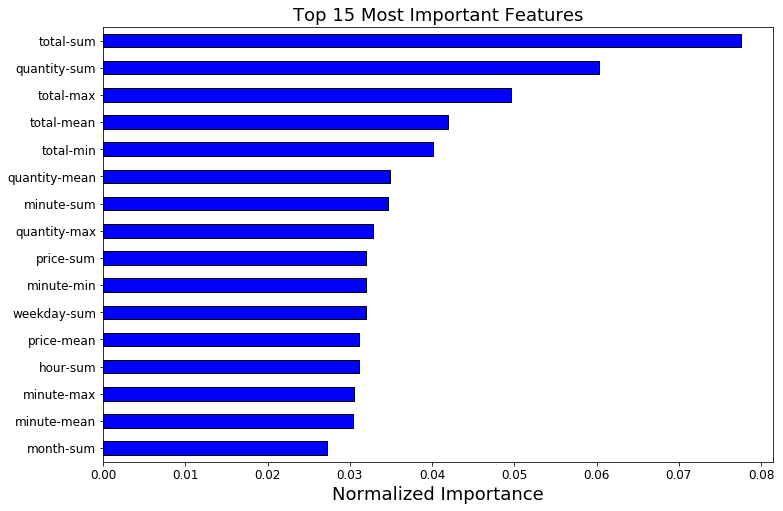

In [33]:
_ = plot_feature_importances(june_fi)

We can conclude from the metrics that manual feature engineering now outperforms the baseline if we use all of the previous information. Looking at the feature importances, they seem to make sense in the domain of the problem. However, I'm not entirely convinced that all of the data is allowable for this problem. Taking on this problem by hand introduces many opportunities for error. Companies routinely struggle with the issue of using only valid data and often will design a model that does well in development but then fails in deployment because it was trained on data that won't actually be available in the real world. 

Featuretools can automatically handle the cutoff times for us, ensuring that all of our features are built using valid data. If the method exists and can be used to safely build features, then what's the downside to using it as opposed to doing everything by hand? Finally, let's take a look at a comparison between manual and automated feature engineering performance.

# Comparison to Automated Feature Engineering

To compare the performance of Automated Feature Engineering, the baseline model, and manual feature engineering, we can plot the ROC AUC curves for each month. A ROC AUC curve that is strictly higher than the curve for another classifier indicates a better classifier. 

In [34]:
%%capture

for month in range(4, 13):
    _, probs = predict_month_expanded(month, True)
    temp_df = pd.DataFrame({'Manual': probs, 'month': month})
    
    if month == 4:
        probs_df = temp_df.copy()
    
    else:
        probs_df = probs_df.append(temp_df)

In [35]:
probs_df['label'] = list(labels.loc[labels['month'] > 3]['label'])

In [36]:
auto_probs = pd.read_csv('../input/auto_probs.csv', index_col = 0)
auto_probs.head()

Automated  month  label
0      0.152      4      0
1      0.032      4      1
2      0.134      4      1
3      0.098      4      0
4      0.313      4      0


September ROC AUC Performance:
Baseline: 0.62499
Manual: 0.76909
Automated: 0.87651

October ROC AUC Performance:
Baseline: 0.61645
Manual: 0.76497
Automated: 0.85939

November ROC AUC Performance:
Baseline: 0.61947
Manual: 0.77728
Automated: 0.87987

December ROC AUC Performance:
Baseline: 0.69502
Manual: 0.80234
Automated: 0.90784


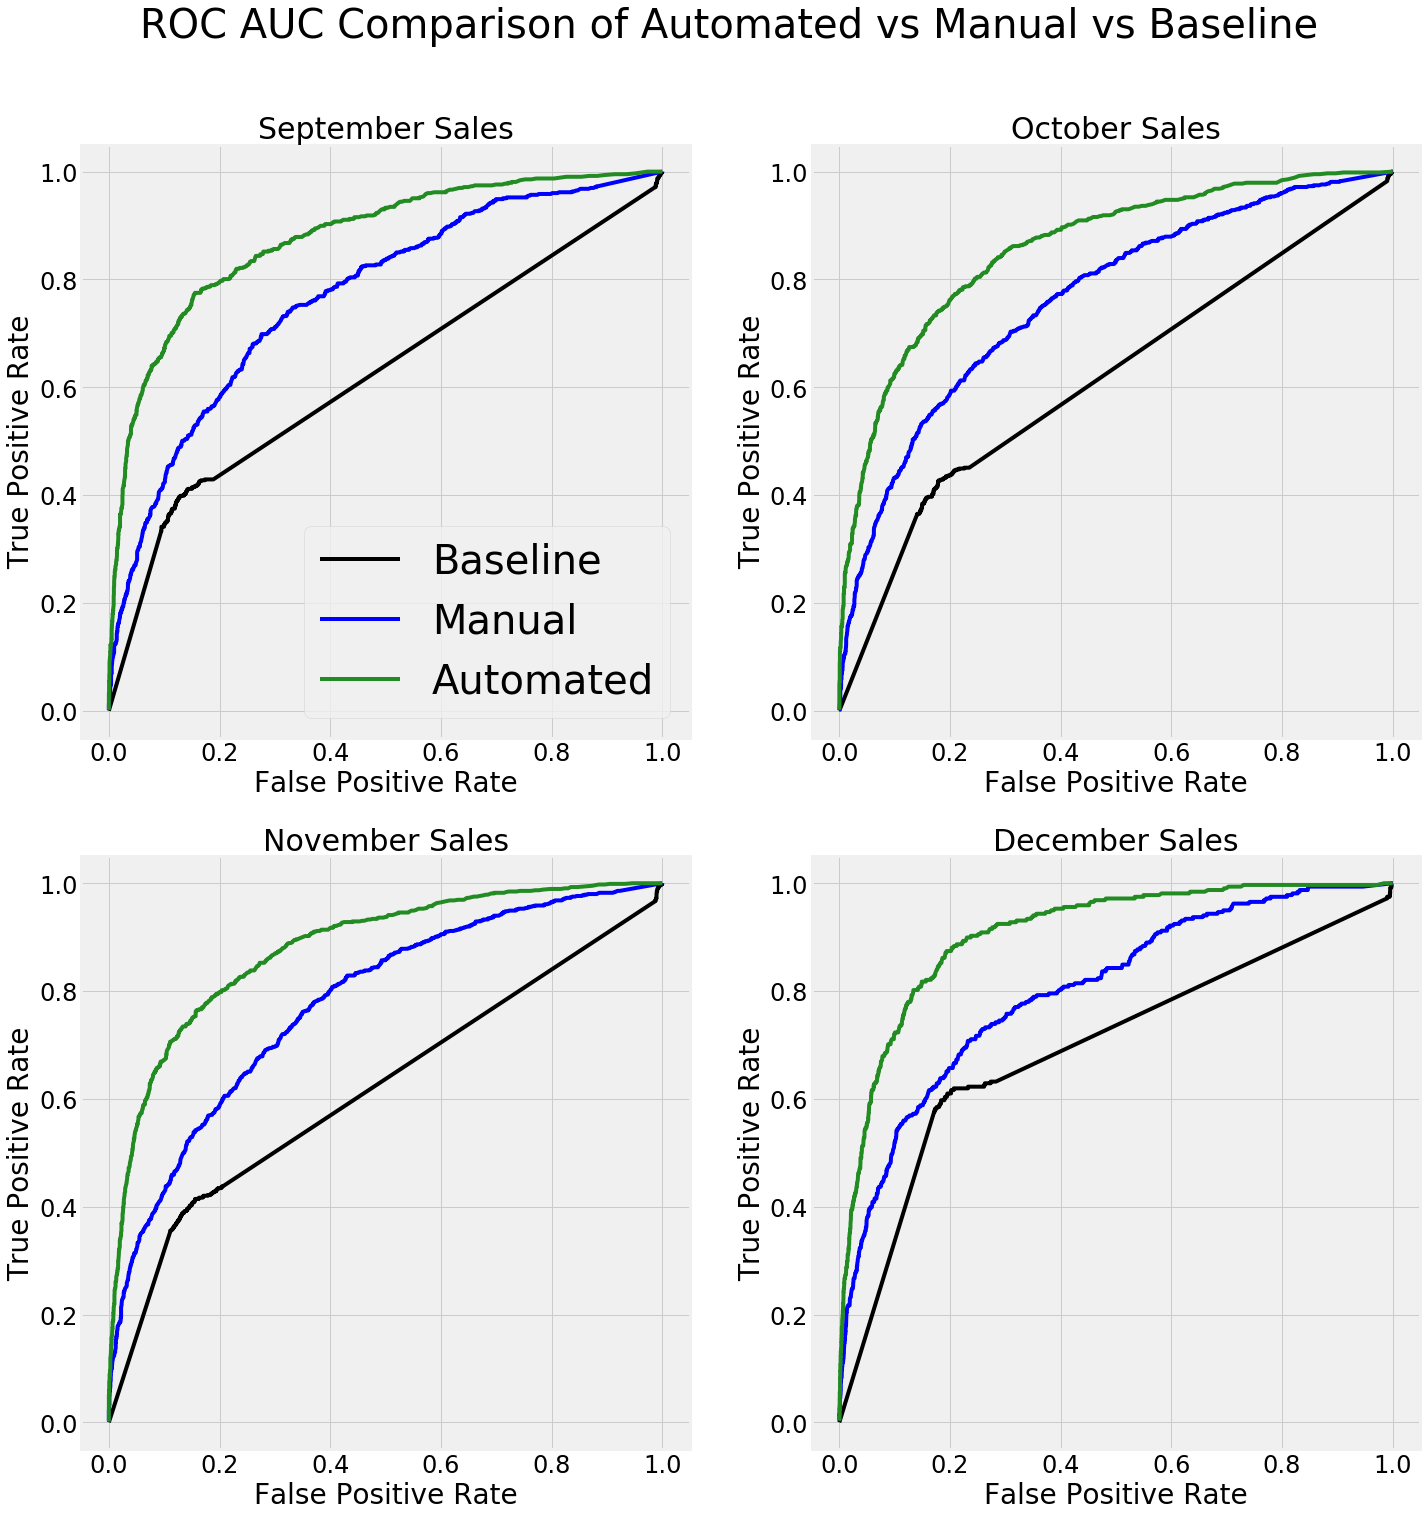

In [37]:
import calendar
plt.figure(figsize = (24, 24))
plt.style.use('fivethirtyeight')
plt.rcParams['font.weight'] = 'normal'

for month, month_data in probs_df.groupby('month'):
    
    if month < 9:
        next
    else:
    
        auto_probs_month = auto_probs.loc[auto_probs['month'] == month].copy()

        plt.subplot(2, 2, month - 8)

        # Informed baseline
        baseline = informed_baseline(month, quiet = True)
        fpr, tpr, _ = roc_curve(baseline['label'], baseline['probability'])
        baseline_score = roc_auc_score(baseline['label'], baseline['probability'])
        print(f'\n{calendar.month_name[month]} ROC AUC Performance:')
        print(f'Baseline: {round(baseline_score, 5)}')
        
        plt.plot(fpr, tpr, label = 'Baseline', color = 'black')


        # Manual Predictions
        fpr, tpr, _ = roc_curve(month_data['label'], month_data['Manual'])
        manual_score = roc_auc_score(month_data['label'], month_data['Manual'])
        print(f'Manual: {round(manual_score, 5)}')
        plt.plot(fpr, tpr, label = 'Manual', color = 'blue')

        # Automated Predictions
        fpr, tpr, _ = roc_curve(auto_probs_month['label'], auto_probs_month['Automated'])
        plt.plot(fpr, tpr, label = 'Automated', color = 'forestgreen')
        auto_score = roc_auc_score(auto_probs_month['label'], auto_probs_month['Automated'])
        print(f'Automated: {round(auto_score, 5)}')
        
        plt.xlabel('False Positive Rate', size = 28); plt.ylabel('True Positive Rate', size = 28);

        if month == 9:
            plt.legend(prop = {'size': 40});

        plt.xticks(size = 24); plt.yticks(size = 24);
        plt.title(f'{calendar.month_name[month]} Sales', size = 30);

plt.suptitle('ROC AUC Comparison of Automated vs Manual vs Baseline', size = 40, y = 0.96)
plt.subplots_adjust();

# Conclusions

Given the same time for manual feature engineering as automated feature engineering, the automated approach took a decisive victory. The manual approach suffered because I had to be extremely cautious about not using invalid data and therefore had to resort to basically re-implementing the functionality of Featuretools. I'm still not quite sure if my features from the manual engineering are entirely valid! 

Overall, the takeaways from this project were:

    * For the same time investment, automated feature engineering delivers a significantly better performing model. 
    * Featuretools automatically is able to filter based on an array of cutoff times leaving us free from having to worry about using invalid data
    * The most important features from automated feature engineering are useful in the context of the problem
    * Automated feature engineering overall delivers a better predictive pipeline for the same amount of time and assures us our model deployment will be as successful as the development
    
Sure, we could probably achieve the same results manually as we do with featuretools, but if a superior tool exists, then why would we not take advantage of it? Data science is about extracting meaning from data using the right tool for the job, and automated feature engineering is clearly the correct choice for this and many other machine learning problems.